# OR Tools for Robot & Drone VRP

2023/11/15

- Drone 的速度找 Reference
- 用演算法解 Robot, 不需要解 VRPTW (Greedy, GA)
- 最終比較在不同組合下比較 10-30 次
- Robot 的點受到移動速度影響，目前實務傾向於社區/校園服務、未來研究: 可移動的 Helper

##### **目標**

比較 **VRP**、**Drone VR**、**Robot VRP**、**Drone & Robot VRP**，四種組合在不同參數下的表現

##### **表現指標**
- 總路徑時間
- 總路徑長度
- 時間複雜度 (演算法計算時間)
- 空間複雜度 (記憶體使用量) 

##### **參數**
- 不同地圖大小 (5x5, 10x10, 20x20)
- 不同客戶數量 (530, 430, 300) (從 30 次的重複模擬實驗結果取平均, 趨近於 8 小時的 Nodes 數量)
- 不同車輛數量 (1, 2, 3, 4)
- 蒙地卡羅模擬次數 10 次以上

##### **實驗假設**

- 每個客戶點的貨物數量、尺寸皆相同
- 每個客戶點的服務時間皆為 1 分鐘
- 實驗載具共有 Truck、Drone 與 Robot 三種載具
- 一台 Truck 配置 1 台 Drone 與 Robot，且 Drone 與 Robot 可以同時在路上跑
- Drone 與 Robot 可以由 Truck 於任意客戶點中派出與回收，派出與回收各需要花費 1 分鐘
- Truck 可以多次派出 Drone 與 Robot
- 若 Truck 抵達回收點時 Drone 與 Robot 尚未返回，需記錄等待時間
- 司機可以有等待時間，但不能提前 10 分鍾以上到達
- Truck 載具的速度為 60 km/hr，使用曼哈頓距離計算，載貨量為 **服務點 ÷ 車輛數** (考量平均工作量)
- Drone 載具的速度為 80 km/hr，使用歐式距離計算，每次只能載 1 個貨物, 電池續航力為 60 分鐘
- Robot 載具的速度為 30 km/hr，使用曼哈頓距離計算，每次只能載 4 個貨物, 電池續航力為 120 分鐘

##### **Drone 挑選方法說明**

- 距離計算單位採歐幾里德距離
- 每台 Truck 只有一台 Drone
- 以 OR-Tools 初始解分組, 找出每組中最適合派給 Drone 的點
- 篩選出最近點距離最遠的 n 個點作為 Drone 效益最高的點, n 設定為 25 百分位數
- 設定其原路徑為 Drone 的可能發收站, 並排除掉 Node 為其他 Drone 發收站的點

##### **Robot 挑選方法**

- 每個 Truck 只有一輛 Robot
- 從 Initial Solution 中抓出最短的路徑組合 (6 個造訪點一組, 如數量 <= 6 則不考慮出車)
- 路徑組合的造訪時間不可超過 Robot 電池續航力
- 根據距離排序, 排除掉 Node 重複的組合
- 篩選出前 25 百分位數近的組合
- 每台車只會派出 Robot 一次 (限制式過多可能會無解)

In [1]:
import random as rd
import numpy as np
import pandas as pd
import math
import copy as copy
# OR-Tools
from ortools.constraint_solver import routing_enums_pb2 
from ortools.constraint_solver import pywrapcp 
# 記錄時間/空間複雜度
import time 
import tracemalloc
# 視覺化結果
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Parameters: 實驗參數設定

In [2]:
# [實驗控制變數] 
# 地圖大小(km) | 服務點數量 | 車輛數量
# MAX_X, MAX_Y = 20, 20
# NUM_NODES = 30
# NUM_VEHICLES = 1

# 站點服務時間
SERVICE_TIME = 1

# [Vehicle]
# 時速 60km | 每台車有最大移動距離(固定) | 貨物重量相同 | 本實驗不考慮車輛成本, 故每台車可載貨物數量 = (站點/車輛數)
VEHICLE_SPEED = 60
VEHICLE_MAX_DISTANCE = 9999999
# VEHICLE_CAPACITIES = int(NUM_NODES / NUM_VEHICLES)

# [Drone]
# 時速 80km | 續航力 60 min | 採用歐幾里德距離 | 負責離群值 | 派出與收回載具各需要 1 分鐘
DRONE_SETUP_TIME = 1  # 發送 & 收回 Drone 的準備時間
DRONE_CAPACITIES = 1
DRONE_SPEED = 80
DRONE_BATTERY_LIFE = 60

# [Robot]
# 時速 30km | 續航力 120 min | 負責高密度點 | 派出與收回載具各需要 1 分鐘
ROBOT_SETUP_TIME = 1
ROBOT_CAPACITIES = 4
ROBOT_SPEED = 30
ROBOT_BATTERY_LIFE = 120

## Model: 資料層設定

In [3]:
# **controls = dict(map_size=(20, 20), num_nodes=20, num_vehicle=1, trials=10)
def create_data_model(**controls):

    NUM_NODES = controls["num_nodes"]
    MAX_X, MAX_Y = controls["map_size"][0], controls["map_size"][1]
    NUM_VEHICLES = controls["num_vehicle"]
    VEHICLE_CAPACITIES = controls["num_nodes"] // controls["num_vehicle"] # 如果非整數需分配給其他車輛
    
    data = {}
    data["num_locations"] = [(round(np.random.uniform(0, MAX_X),2), round(np.random.uniform(0, MAX_Y),2)) for i in range(NUM_NODES)]
    data["num_locations"][0] = (round((MAX_X / 2), 2), round((MAX_Y / 2), 2)) 
    data["distance_matrix"] = compute_manhattan_distance_matrix(data["num_locations"]) # 距離矩陣必須為整數, 否則無法在 OR-Tools 中求解
    data["e_distance_matrix"] = compute_euclidean_distance_matrix(data["num_locations"]) # 歐幾里德距離, 取小數第二位(drone 使用)
    data["time_matrix"] = compute_time_matrix(data["distance_matrix"]) # 最小單位分鐘
    data["num_nodes"] = NUM_NODES
    data["num_vehicles"] = NUM_VEHICLES
    data["depot"] = 0 # Depot 的索引值
    data["time_windows"] = []
    data["initial_routes"] = [] # 如果有初始解可以套用
    data["demands"] = [1 for i in range(NUM_NODES)]
    data["demands"][0] = 0
    data["vehicle_capacities"] = [VEHICLE_CAPACITIES for i in range(NUM_VEHICLES)]
    if NUM_NODES % VEHICLE_CAPACITIES > 0:
        for i in range(NUM_NODES % VEHICLE_CAPACITIES):
            data["vehicle_capacities"][i] += 1

    # 三個載具負責的 node 索引值
    data["vehicle"] = []
    data["drone"] = []
    data["robot"] = []    
    return data

def compute_manhattan_distance_matrix(nodes):
    distance_matrix = []
    for node_i in nodes:
        distances = []
        for node_j in nodes:
            if node_i == node_j:
                distances.append(0)
            else:
                manhattan_distance = np.sum(np.abs(np.array(node_i) - np.array(node_j)))
                distances.append(int(manhattan_distance))
        distance_matrix.append(distances)
    return distance_matrix

def compute_euclidean_distance_matrix(nodes):
    distance_matrix = []
    for node_i in nodes:
        distances = []
        for node_j in nodes:
            if node_i == node_j:
                distances.append(0)
            else:
                euclidean_distance = np.sqrt((node_i[0] - node_j[0])**2 + (node_i[1] - node_j[1])**2)
                distances.append(round(euclidean_distance, 2))
        distance_matrix.append(distances)
    return distance_matrix

def compute_time_matrix(distance_matrix):
    time_matrix = []
    for i in distance_matrix:
        time_matrix.append(list(map(lambda x: int(x / VEHICLE_SPEED * 60), i)))
    return time_matrix

# 重置 Node 的貨物需求
def reset_demands(data, **controls):

    NUM_VEHICLES = controls["num_vehicle"]
    VEHICLE_CAPACITIES = int(controls["num_nodes"] / controls["num_vehicle"])
    data["demands"] = [1 for i in range(data["num_nodes"])]
    data["demands"][0] = 0
    data["vehicle_capacities"] = [VEHICLE_CAPACITIES for i in range(NUM_VEHICLES)]
    return data

## Controller: 控制層設定

In [14]:
# 取得目標值(時間和/分鐘): 提供路徑, 速度, 參考距離矩陣, 會考量每個點的服務時間
def get_objective_value(data, route, speed=VEHICLE_SPEED, matrix='distance_matrix'):
    objective_value = 0
    for i in range(len(route) - 1):
        objective_value += data[matrix][route[i]][route[i + 1]] + SERVICE_TIME
    objective_value = int(objective_value / speed * 60)
    return objective_value

# 計算每台車的總等待時間
def get_waiting_time(data, routes, sidekick_routes, name):
    assert name == 'drone' or name == 'robot'
    print(f'\n{name}')
    total = 0
    waiting_time_list = [[] for i in range(len(sidekick_routes))]
    for i, group in enumerate(sidekick_routes):
        for j, r_s in enumerate(group): # 每筆路徑   
            speed_unit = DRONE_SPEED if name == 'drone' else ROBOT_SPEED
            dur_s = get_objective_value(data, r_s, speed_unit, 'e_distance_matrix')
            start, end = r_s[0], r_s[-1]
            print(routes[i])
            r_v = routes[i][routes[i].index(start):routes[i].index(end)+1]
            dur_v = get_objective_value(data, r_v, VEHICLE_SPEED)         
            print(f'Sidekick: {r_s}, Vehicle: {r_v}')
            print(f'-T(s): {dur_s}, T(v): {dur_v}')
            if dur_s > dur_v: # 如果 sidekick 時間比較長, 記錄為等待時間
                print('-Wait for:', (dur_s - dur_v))
                waiting_time_list[i].append(dur_s - dur_v)  
                total += (dur_s - dur_v)
        if waiting_time_list[i] == []:
            waiting_time_list[i] = [0]
    return waiting_time_list

# 計算每台車輛的總服務時間: 目標值 + 等待時間; VRP 問題不會有等待時間
def get_travelling_time(data, routes, drone_waiting=[], robot_waiting=[]):

    total_dist, total_time, total_waiting  = [], [], []

    if len(drone_waiting) > 0 or len(robot_waiting) > 0:
        for index, route in enumerate(routes):
            distance = get_objective_value(data, route)
            duration = distance + np.sum(drone_waiting[index]) + np.sum(robot_waiting[index])
            waiting = np.sum(drone_waiting[index]) + np.sum(robot_waiting[index])
            total_dist.append(distance)
            total_time.append(duration)
            total_waiting.append(waiting)
            print(f'Vehicle {index}: {distance} km, {duration} mins, wait for {waiting} mins')
    else:
        for index, route in enumerate(routes):
            distance = get_objective_value(data, route)
            total_dist.append(distance)
            total_time.append(distance)
            total_waiting.append(0)
            print(f'Vehicle {index}: {distance} km, {distance} mins') 
    print(f'\nTotal distance of all routes: : {np.sum(total_dist)} km')
    print(f'Maximum travel time: {max(total_time)} mins')
    return np.sum(total_dist), max(total_time), np.sum(total_waiting)

def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    total_distance = 0
    total_load = 0

    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        plan_output = f"Route for vehicle {vehicle_id}:\n"
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data["demands"][node_index]
            plan_output += f" {node_index} ({route_distance}) -> "
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id
            )
        plan_output += f" {manager.IndexToNode(index)} ({route_distance})\n"
        plan_output += f"Distance of the route: {route_distance} km\n"
        plan_output += f"Load of the route: {route_load}\n"
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
    
    print(f"Total distance of all routes: {total_distance} km")
    print(f"Total load of all routes: {total_load}")

# Save routes to a list or array
def get_routes(solution, routing, manager):
    """Get vehicle routes from a solution and store them in an array."""
    # Get vehicle routes and store them in a two dimensional array whose
    # i,j entry is the jth location visited by vehicle i along its route.
    routes = []
    for route_nbr in range(routing.vehicles()):
        index = routing.Start(route_nbr)
        route = [manager.IndexToNode(index)]
        while not routing.IsEnd(index):
            index = solution.Value(routing.NextVar(index))
            route.append(manager.IndexToNode(index))
        routes.append(route)
    return routes

# OR Tools = manager + routing + search_parameter = solution
def solve_routing_problem(data):
    ''' 路徑管理員 RoutingIndexManager '''
    # data 中有新資料需於此處引用
    manager = pywrapcp.RoutingIndexManager(
        len(data["distance_matrix"]), data["num_vehicles"], data["depot"]
    )
    ''' 路徑資料 RoutingModel '''
    routing = pywrapcp.RoutingModel(manager)
    # 計算 node 貨物需求的工具
    def demand_callback(from_index):
        from_node = manager.IndexToNode(from_index)
        return data["demands"][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data['vehicle_capacities'],  # vehicle maximum capacities
        True,  # start cumul to zero
        "Capacity",
    )

    # 計算 node 間距離單位的工具, 調整距離計算方法可從函式 return 中修改
    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index) # 取得開始到結束點的索引值
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node] # 若題目為 VRPTW 需回傳 data["time_matrix"]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback) # 設定所有車輛距離(arc)間的評估單位
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    # routing.SetArcCostEvaluatorOfVehicle() # 打開後可定義其他車輛距離的評估單位

    # 設定車輛行駛中累積的變量, VRPTW 時需將 demension_name 調整為 "Time"
    routing.AddDimension(
        transit_callback_index,
        0,  # 車輛最大等待時間, VRPTW 用
        VEHICLE_MAX_DISTANCE,  # 車輛最大行駛距離
        True,  # 每輛車路線開始時，累計變數是否設為零 (VRPTW 時需調整為 False, 讓時間可累積)
        "Distance",
    )
    distance_dimension = routing.GetDimensionOrDie("Distance")
    # distance_dimension.SetGlobalSpanCostCoefficient(0) # 成本係數設定成 100 會無法跑少數量的車輛路線

    # 設計懲罰項: AddDisjuntion() 只能呼叫一次, 要將 node 排除在路徑中需要調整 Capacity
    penalty = 1000
    for node in range(1, len(data["distance_matrix"])):
        routing.AddDisjunction([manager.NodeToIndex(node)], penalty)

    # 平衡車輛 loading, 避免部分車輛跑有路線
    for vehicle_id in range(data['num_vehicles']):
        routing.SetVehicleUsedWhenEmpty(True, vehicle_id)

    routing.AddConstantDimension(
        1, # +1 for each visit (note start node is counted so unused vehicle is still 1)
        data["num_nodes"] // data["num_vehicles"] + 2, # max visit allowed,  hard limit
        True,  # start cumul to zero
        "Counter")
        
    counter_dimension = routing.GetDimensionOrDie("Counter")
    for vehicle_id in range(manager.GetNumberOfVehicles()):
        index = routing.End(vehicle_id)
        counter_dimension.SetCumulVarSoftLowerBound(index, 2, 100000) # penalty of 100000 for each empty vehicle since counter will be 1 aka (2 - 1) * 100_000  

    ''' 啟發式演算法參數 search_parameters '''
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC # 最快求解法, 預設為 PATH_CHEAPEST_ARC '''
    )
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH     # 開啟後會改用 guided local search 求解 local minimum (GREEDY_DESCENT, TABU_SEARCH, Simulated Annealing...)
    )
    search_parameters.time_limit.seconds = 5 # 搜尋時間限制
    # search_parameters.log_search = True # 開啟後會顯示每次搜尋迭代(log)
    search_parameters.solution_limit = 100 # 解決方案限制
    
    routing.CloseModelWithParameters(search_parameters) # 提供初始解時關閉搜尋參數
    # initial_solution = routing.ReadAssignmentFromRoutes(data["initial_routes"], True) # 求解前如果想提供初始路徑解可打開

    solution = routing.SolveWithParameters(search_parameters) # 將準備好的 search_parameter 提供給 OR Tools 求解
    if solution: # 有找到解的話顯示答案
        routes = get_routes(solution, routing, manager)
        print(f'Routes: {routes}, Length: {len(routes[0])}')
        # print_solution(data, manager, routing, solution)
        return routes
    else:
        print('No solution!')
        return []

## View: 畫面顯示

In [5]:
def plot_map(routes, drone_routes=[], robot_routes=[], **controls):

    plt.figure(figsize=(7, 7))
    plt.grid(color='gray', linestyle='-', linewidth=1, alpha=0.2)
    plt.xlim(-1, controls["map_size"][0]+1)
    plt.ylim(-1, controls["map_size"][1]+1) 
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    color_palette = [(0, 0.5, 1), (0.8, 0, 0), (0.0, 0.6, 0.2), (1, 0.7, 0.4)]
    passed_nodes = []

    def draw_line(route, color='gray'):
        arrow_kwargs = dict(length_includes_head=True, head_width=0.3, head_length=0.6, color=color, alpha=0.8)
        for index, node in enumerate(route):
            if index < len(route) - 1:
                start_loc = data['num_locations'][route[index]]
                end_loc = data['num_locations'][route[index + 1]] 
                plt.arrow(x=start_loc[0], y=start_loc[1], dx=(end_loc[0] - start_loc[0]), dy=(end_loc[1] - start_loc[1]), **arrow_kwargs)
    
    def draw_node(node, color='gray', marker='o'):
        text_kwargs = dict(s=str(node), fontsize=7.5, color="white", horizontalalignment='center', verticalalignment='center')
        node_kwargs = dict(s=300, color=color, alpha=0.8, edgecolors='black', marker=marker)
        loc = data['num_locations'][node]
        plt.scatter(x=loc[0], y=loc[1], **node_kwargs)
        plt.text(x=loc[0], y=loc[1], **text_kwargs)
        passed_nodes.append(node)

    if len(routes) > 0:
        # Draw VRP solution
        for i_route, route in enumerate(routes):
            RGB_color = color_palette[i_route]
            draw_line(route, RGB_color)
            # Draw vehicle nodes
            for i in route:
                if i != 0:
                    draw_node(node=i, color=RGB_color)
            # Draw drone nodes
            if len(drone_routes) > 0:
                for route in drone_routes[i_route]:
                    drone_color = 'gray'
                    for index, node in enumerate(route):
                        if index != (len(route) - 1):
                            draw_line(route, color=drone_color)
                        if index == 1:
                            draw_node(node, color=drone_color, marker='D')         
            # Draw robot nodes
            if len(robot_routes) > 0:
                for route in robot_routes[i_route]:
                    robot_color = 'gray'
                    for index, node in enumerate(route):
                        if index != (len(route) - 1):
                            draw_line(route)
                        if 0 < index < (len(route) - 1):
                            draw_node(node, color=robot_color, marker='H')
        # Draw un-passed nodes    
        unpassed_nodes = [i for i in range(data["num_nodes"]) if i not in passed_nodes]
        if len(unpassed_nodes) > 0:
            for index in unpassed_nodes:
                draw_node(index)
        # Draw depot
        draw_node(node=0, color='black', marker='s')   
    # No route, plot map & nodes
    else:
        if len(data['num_locations']) > 0:
            for index, node in enumerate(data['num_locations']):
                draw_node(index) # depot
            draw_node(node=0, color='black', marker='s')
        else:
            print("No data.")

## VRP 解題方法說明

num_locations  \
0  [(10.0, 10.0), (6.38, 8.97), (14.12, 13.29), (...   

                                     distance_matrix  \
0  [[0, 4, 7, 13, 8, 12, 11, 9, 7, 1, 16, 3, 10, ...   

                                   e_distance_matrix  \
0  [[0, 3.76, 5.27, 9.96, 6.28, 9.35, 9.41, 7.65,...   

                                         time_matrix  num_nodes  num_vehicles  \
0  [[0, 4, 7, 13, 8, 12, 11, 9, 7, 1, 16, 3, 10, ...        100             2   

   depot time_windows initial_routes  \
0      0           []             []   

                                             demands vehicle_capacities  \
0  [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...           [50, 50]   

  vehicle drone robot  
0      []    []    []

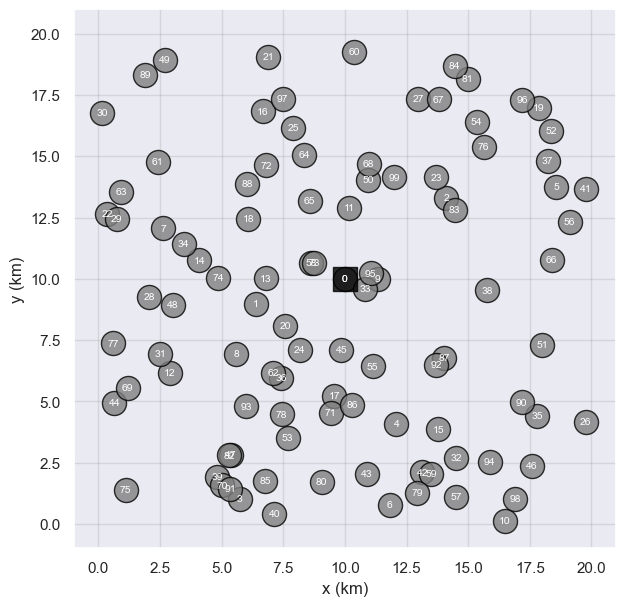

In [6]:
# Set data & control parameter
controls = dict(map_size=(20, 20), num_nodes=100, num_vehicle=2)
data = create_data_model(**controls)

plot_map(routes=[], **controls)
pd.json_normalize(data)

### VRP

Routes: [[0, 54, 99, 53, 33, 58, 98, 29, 46, 82, 77, 11, 2, 18, 66, 63, 19, 88, 73, 50, 97, 16, 64, 57, 17, 10, 3, 71, 67, 90, 55, 51, 75, 47, 39, 12, 69, 87, 60, 70, 45, 35, 21, 23, 38, 25, 22, 40, 7, 56, 0], [0, 42, 31, 62, 68, 5, 72, 44, 9, 13, 36, 41, 76, 4, 81, 83, 84, 49, 24, 65, 15, 92, 28, 34, 86, 95, 27, 93, 59, 43, 14, 30, 37, 26, 94, 79, 89, 78, 20, 91, 52, 74, 96, 8, 6, 48, 32, 85, 1, 80, 61, 0]], Length: 51


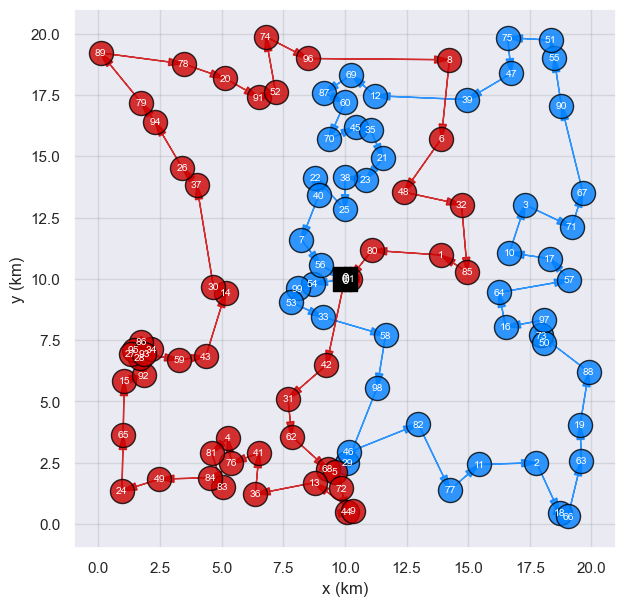

In [9]:
VRP_result = solve_routing_problem(data)
plot_map(routes=VRP_result, **controls)

### VRP + Drone

In [47]:
def select_drone_nodes(data, routes, excludes=[]):

    # 找出最近距離 Node 排序
    nearest_dists = []
    for i in data['e_distance_matrix']:
        sorted_i = sorted(i)
        nearest_dists.append(sorted_i[1])
    sorted_nearest_indexes = np.argsort(nearest_dists).tolist()[::-1]
    sorted_nearest_indexes = sorted_nearest_indexes[:int(data["num_nodes"])] 
    sorted_nearest_indexes.remove(0)

    # 將 Node 分配到初始解車輛路徑中
    drone_nodes = [[] for i in range(len(routes))]
    for i, route in enumerate(routes):
        for j in sorted_nearest_indexes:
            drone_nodes[i].append(j) if j in route else None
        drone_nodes[i] = drone_nodes[i][:int(len(route)/4)] # 根據中位數篩選出前 25% 最遠的點

    # 如果有先解出 Robot 點, 需將 Robot 的收發站排除掉
    if len(excludes) > 0:
        for i, group in enumerate(excludes):
            for j, nodes in enumerate(group):
                for n in nodes:
                    drone_nodes[i].remove(n) if n in drone_nodes[i] else None

    # 取得 Drone 的合適路徑, 原路徑鄰的點不能為其他 Drone 點
    drone_routes = [[] for i in range(len(routes))]
    for i, group in enumerate(drone_nodes):
        exclusion = []
        for n in group:
            if n not in exclusion:
                start, end = routes[i].index(n)-1, routes[i].index(n)+1
                exclusion.append(routes[i][start])
                exclusion.append(routes[i][end])
                route = [routes[i][start], n, routes[i][end]]
                drone_routes[i].append(route)                   

    print('Drone Routes:', drone_routes)
    return drone_routes

Routes: [[0, 38, 64, 88, 1, 94, 48, 50, 89, 4, 85, 77, 56, 65, 71, 95, 43, 44, 70, 67, 7, 28, 39, 52, 54, 69, 26, 25, 6, 22, 82, 32, 9, 73, 10, 30, 91, 90, 2, 76, 66, 45, 57, 18, 5, 31, 83, 13, 78, 80, 0], [0, 15, 74, 96, 46, 35, 23, 20, 72, 60, 33, 12, 58, 34, 61, 53, 19, 36, 27, 92, 86, 8, 49, 37, 87, 79, 63, 21, 68, 14, 24, 62, 59, 16, 81, 29, 11, 98, 17, 47, 51, 40, 42, 97, 55, 99, 93, 84, 3, 41, 75, 0]], Length: 51
Drone Routes: [[[45, 57, 18], [30, 91, 90], [76, 66, 45], [26, 25, 6], [31, 83, 13], [54, 69, 26], [4, 85, 77], [7, 28, 39]], [[15, 74, 96], [24, 62, 59], [17, 47, 51], [27, 92, 86], [20, 72, 60], [16, 81, 29]]]
[[[45, 57, 18], [30, 91, 90], [76, 66, 45], [26, 25, 6], [31, 83, 13], [54, 69, 26], [4, 85, 77], [7, 28, 39]], [[15, 74, 96], [24, 62, 59], [17, 47, 51], [27, 92, 86], [20, 72, 60], [16, 81, 29]]]

drone
Sidekick: [45, 57, 18], Vehicle: [45, 18]
-T(s): 7, T(v): 8
Sidekick: [30, 91, 90], Vehicle: [30, 90]
-T(s): 7, T(v): 6
-Wait for: 1
Sidekick: [76, 66, 45], Ve

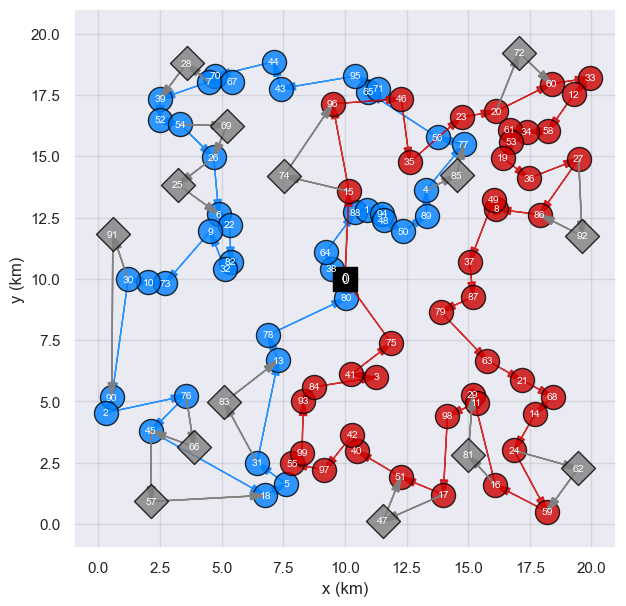

In [11]:
# 解 VRP -> 分開挑選 Drone 點 -> 連接路線
data = create_data_model(**controls)
routes = solve_routing_problem(data)
drone_routes = select_drone_nodes(data, routes)
print(drone_routes)
# 調整車輛路線
for index, group in enumerate(drone_routes):
    for r in group:
        routes[index].remove(r[1])

drone_waiting = get_waiting_time(data, routes, drone_routes, 'drone')

plot_map(routes=routes,drone_routes=drone_routes, robot_routes=[], **controls)

### VRP + Robot

1. 解 VRP
2. 獨立成 TSP
3. 決定 Robot Node
4. Greedy 解 TSP + Robot Constraint (原解法: 解 VRPTW)

In [7]:
def select_robot_nodes(data, routes):

    robot_routes = [[] for i in range(len(routes))]
    
    for index, route in enumerate(routes):
        # print('Choosing the nodes for Robot:', route)
        if len(route) <= 6:
            continue
        route_filter = []
        for j in range(len(route)):
            if j <= (len(route) - ROBOT_CAPACITIES - 2):
                robot_route = route[j:j + ROBOT_CAPACITIES + 2]            
                r_dur = get_objective_value(data, robot_route, ROBOT_SPEED)
                if r_dur <= ROBOT_BATTERY_LIFE: # 排除超過電池續航力(ROBOT_BATTERY_LIFE)的路徑組合
                    # print(f'Route {j}: {robot_route}, Duratoin: {r_dur}')
                    route_filter.append({ 'route': robot_route, 'duration': r_dur }) 
        print(route_filter)
        # 根據最短時間(duration)排序, 並排除掉重複 Node 的路徑組合
        route_filter.sort(key=lambda x: x['duration'])
        if len(route_filter) >= 4:
            route_filter = route_filter[:int(len(route_filter)/4)] # 保留 25% 路徑組合
        best_routes = [route_filter[0]['route']]
        print(best_routes)
        for r_dict in route_filter:
            overlap = 0
            for best_r in best_routes:
                if len(set(best_r) & set(r_dict['route'])) > 0:
                    overlap += 1
                    break
            if overlap == 0:
                best_routes.append(r_dict['route'])
        robot_routes[index] = best_routes

    # 每台車只會派出 Robot 一次 (之後再調整成多次派出)
    robot_routes = [[robot_routes[i][0]] for i in range(len(routes))]
    print('Robot Routes:', robot_routes)
    return robot_routes

def adjust_route(route, robot_group):
    # print(f"Route: {route}")
    a_route = route.copy()
    a_robot_group = robot_group.copy()

    for index, route_r in enumerate(robot_group):
        route_t = [route_r[0], route_r[-1]]
        dur_r, dur_t  = get_objective_value(data, route_r, ROBOT_SPEED), get_objective_value(data, route_t)
        if dur_r > dur_t:
            # forward stepwise search
            route_f = route[route.index(route_t[-1])+1:] if route_t[-1] != 0 else [0]
            diff_abs = [abs(get_objective_value(data, [route_t[0]] + route_f[:i] + [route_t[-1]]) - dur_r) for i in range(len(route_f))]
            new_route = [route_t[0]] + route_f[:diff_abs.index(min(diff_abs))] + [route_t[-1]]
            
            # backward stepwise search (if truck needs waiting)
            if get_objective_value(data, new_route) < dur_r:
                # print("-Waiting time:", dur_r - get_objective_value(data, new_route))
                route_b = route[:route.index(route_t[-1])]
                for i in range(2 ,len(route_b)):
                    start = route_b[-i]
                    route_rb = [start] + route_r[1:]
                    route_tb = route[route.index(start):route.index(route_r[0])] + new_route
                    dur_rb = get_objective_value(data, route_rb, ROBOT_SPEED)
                    dur_tb = get_objective_value(data, route_tb)
                    # print("-Waiting time:", dur_rb - dur_tb)
                    if dur_tb > dur_rb:
                        new_route = route_tb
                        a_robot_group[index] = route_rb
                        break
            a_route[a_route.index(new_route[0]):a_route.index(new_route[0]) + len(new_route)] = new_route
    print(f"Adjusted Truck Route: {a_route}")
    print(f"Adjusted Robot Route: {a_robot_group}")
    return a_route, a_robot_group

Routes: [[0, 5, 17, 15, 16, 8, 27, 3, 23, 24, 20, 6, 26, 4, 14, 18, 0], [0, 1, 11, 22, 7, 21, 2, 28, 13, 25, 19, 12, 10, 29, 9, 0]], Length: 17
[{'route': [0, 5, 17, 15, 16, 8], 'duration': 42}, {'route': [5, 17, 15, 16, 8, 27], 'duration': 30}, {'route': [17, 15, 16, 8, 27, 3], 'duration': 32}, {'route': [15, 16, 8, 27, 3, 23], 'duration': 42}, {'route': [16, 8, 27, 3, 23, 24], 'duration': 32}, {'route': [8, 27, 3, 23, 24, 20], 'duration': 32}, {'route': [27, 3, 23, 24, 20, 6], 'duration': 40}, {'route': [3, 23, 24, 20, 6, 26], 'duration': 44}, {'route': [23, 24, 20, 6, 26, 4], 'duration': 62}, {'route': [24, 20, 6, 26, 4, 14], 'duration': 72}, {'route': [20, 6, 26, 4, 14, 18], 'duration': 84}, {'route': [6, 26, 4, 14, 18, 0], 'duration': 88}]
[[5, 17, 15, 16, 8, 27]]
[{'route': [0, 1, 11, 22, 7, 21], 'duration': 32}, {'route': [1, 11, 22, 7, 21, 2], 'duration': 28}, {'route': [11, 22, 7, 21, 2, 28], 'duration': 28}, {'route': [22, 7, 21, 2, 28, 13], 'duration': 30}, {'route': [7, 21,

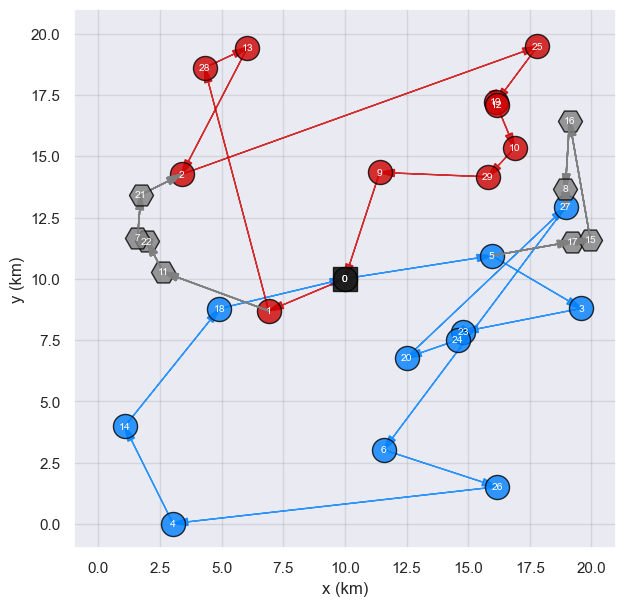

In [15]:
controls = dict(map_size=(20, 20), num_nodes=30, num_vehicle=2)
data = create_data_model(**controls)
routes = solve_routing_problem(data)
robot_routes = select_robot_nodes(data, routes)

# 調整車輛路線
for veh_i, group in enumerate(robot_routes):
    for index, route in enumerate(group):
        exclude_nodes = [item for sublist in robot_routes[veh_i] for item in sublist if 0 < sublist.index(item) < len(sublist) - 1]
        routes[veh_i] = [i for i in routes[veh_i] if i not in exclude_nodes]   
    routes[veh_i], robot_routes[veh_i] = adjust_route(routes[veh_i], group)
    print(routes[veh_i], robot_routes[veh_i])

plot_map(routes=routes,robot_routes=robot_routes, **controls)

# 舊版方法 (VRPTW)
# vrptw_routes = solve_vrptw(data, excludes)
# print('\nRoute for VRPTW:', vrptw_routes)
# if vrptw_routes:
#     robot_waiting = get_waiting_time(data, vrptw_routes, robot_routes, 'robot')
# plot_map(routes=vrptw_routes, drone_routes=[], robot_routes=robot_routes, **controls)

### VRP + Drone + Robot

##### **D&RVRP 路徑規劃流程**

1. 選擇分配給 Drone 的服務點

    - 篩選出最近點距離最遠的 n 個點作為 Drone 效益最高的點，**n 設定為第 25 百分位數**
    - 設定其最鄰近點為 Drone 的可能發收站，並排除掉 Node 為其他 Drone 發收站的點

2. 選擇分配給 Robot 的服務點

3. 未分配的點使用 OR-Tools 求解 Truck 路徑

4. 將 Drone 與 Robot 的路徑加入 Truck 路徑中

    - 決定 Drone 的發收站
    - 決定 Robot 的發收站
    - 需考量到最小回收站等待時間

In [37]:
def get_waiting_time(data, routes, sidekick_routes, name):
    assert name == 'drone' or name == 'robot'
    print(f'\n{name}')
    total = 0
    waiting_time_list = [[] for i in range(len(sidekick_routes))]
    for i, group in enumerate(sidekick_routes):
        for j, r_s in enumerate(group): # 每筆路徑   
            speed_unit = DRONE_SPEED if name == 'drone' else ROBOT_SPEED
            dur_s = get_objective_value(data, r_s, speed_unit, 'e_distance_matrix')
            start, end = r_s[0], r_s[-1]
            print(routes[i])
            r_v = routes[i][routes[i].index(start):routes[i].index(end)+1]
            dur_v = get_objective_value(data, r_v, VEHICLE_SPEED)         
            print(f'Sidekick: {r_s}, Vehicle: {r_v}')
            print(f'-T(s): {dur_s}, T(v): {dur_v}')
            if dur_s > dur_v: # 如果 sidekick 時間比較長, 記錄為等待時間
                print('-Wait for:', (dur_s - dur_v))
                waiting_time_list[i].append(dur_s - dur_v)  
                total += (dur_s - dur_v)
        if waiting_time_list[i] == []:
            waiting_time_list[i] = [0]
    return waiting_time_list

Routes: [[0, 19, 82, 40, 97, 67, 59, 31, 47, 91, 98, 10, 6, 69, 29, 41, 66, 76, 60, 33, 85, 44, 80, 37, 8, 13, 27, 61, 94, 3, 22, 48, 90, 68, 9, 84, 16, 52, 99, 38, 15, 64, 55, 49, 73, 5, 78, 62, 53, 43, 77, 0], [0, 24, 83, 92, 79, 35, 58, 4, 51, 63, 70, 74, 32, 71, 18, 56, 95, 65, 11, 42, 20, 12, 50, 86, 34, 17, 88, 2, 7, 46, 30, 57, 39, 21, 75, 93, 36, 25, 89, 23, 14, 54, 28, 26, 96, 45, 81, 1, 87, 72, 0]], Length: 52
[{'route': [0, 19, 82, 40, 97, 67], 'duration': 30}, {'route': [19, 82, 40, 97, 67, 59], 'duration': 34}, {'route': [82, 40, 97, 67, 59, 31], 'duration': 30}, {'route': [40, 97, 67, 59, 31, 47], 'duration': 26}, {'route': [97, 67, 59, 31, 47, 91], 'duration': 36}, {'route': [67, 59, 31, 47, 91, 98], 'duration': 46}, {'route': [59, 31, 47, 91, 98, 10], 'duration': 46}, {'route': [31, 47, 91, 98, 10, 6], 'duration': 44}, {'route': [47, 91, 98, 10, 6, 69], 'duration': 44}, {'route': [91, 98, 10, 6, 69, 29], 'duration': 32}, {'route': [98, 10, 6, 69, 29, 41], 'duration': 24

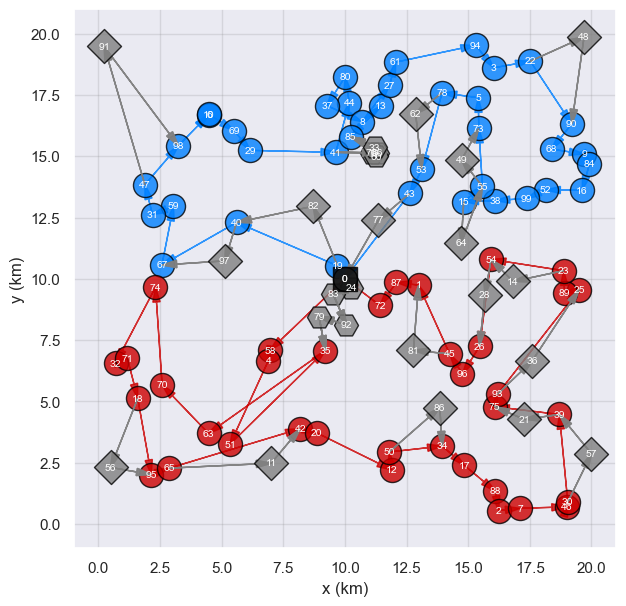

In [55]:
controls = dict(map_size=(20, 20), num_nodes=100, num_vehicle=2)
data = create_data_model(**controls)
routes = solve_routing_problem(data)

robot_routes = select_robot_nodes(data, routes)

for veh_i, group in enumerate(robot_routes):
    for index, route in enumerate(group):
        exclude_nodes = [item for sublist in robot_routes[veh_i] for item in sublist if 0 < sublist.index(item) < len(sublist) - 1]
        routes[veh_i] = [i for i in routes[veh_i] if i not in exclude_nodes]   
    routes[veh_i], robot_routes[veh_i] = adjust_route(routes[veh_i], group)
    print(routes[veh_i], robot_routes[veh_i])

drone_routes = select_drone_nodes(data, routes, excludes=robot_routes)

for index, group in enumerate(drone_routes):
    for r in group:
        routes[index].remove(r[1])

drone_waiting = get_waiting_time(data, routes, drone_routes, 'drone')
robot_waiting = get_waiting_time(data, routes, robot_routes, 'robot')

plot_map(routes=routes, drone_routes=drone_routes, robot_routes=robot_routes, **controls)

## Main: 設定參數與記錄實驗結果

In [160]:
def create_result_model():
    
    result = {}   
    # Parameters
    result["id"] = []
    result["map_size"] = []
    result["num_nodes"] = []
    result["num_locations"] = []
    result["num_vehicles"] = []
    result["vehicle_capacities"] = []
    # Result of VRP
    result["type"] = []
    result["truck_routes"] = []
    result["drone_routes"] = []
    result["robot_routes"] = []
    result["distances"] = []
    result["time"] = []
    result["waiting"] = []
    result["time_complexity"] = []
    result["space_complexity"] = []
    return result

def solve_by_VRP(data):
    start_time = time.time()
    tracemalloc.start()
    '''algorithm starts'''
    routes = solve_routing_problem(data)
    total_dist, travel_time, waiting_time = get_travelling_time(data, routes)
    '''algorithm ends'''
    end_time = time.time()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    time_complexity = round(end_time - start_time, 4)
    space_complexity = round(current / 1024, 4)
    # print(f"Time taken: {time_complexity} seconds")
    # print(f"Memory used: {space_complexity} KB")
    VRP_result = dict(type='VRP', truck_routes=routes,  drone_routes=np.nan, robot_routes=np.nan, distances=total_dist, time=travel_time, waiting=waiting_time, time_complexity=time_complexity, space_complexity=space_complexity)
    return VRP_result

def solve_by_VRPD(data):
    start_time = time.time()
    tracemalloc.start()
    '''algorithm starts'''
    routes = solve_routing_problem(data)
    drone_routes = select_drone_nodes(data, routes)
    for index, group in enumerate(drone_routes):
        for r in group:
            routes[index].remove(r[1])
    drone_waiting = get_waiting_time(data, routes, drone_routes, 'drone')
    robot_waiting = [[] for i in range(len(drone_waiting))]
    total_dist, travel_time, waiting_time = get_travelling_time(data, routes, drone_waiting, robot_waiting)
    '''algorithm ends'''
    end_time = time.time()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    time_complexity = round(end_time - start_time, 4)
    space_complexity = round(current / 1024, 4)
    VRPD_result = dict(type='VRPD', truck_routes=routes, drone_routes=drone_routes, robot_routes=np.nan, distances=total_dist, time=travel_time, waiting=waiting_time, time_complexity=time_complexity, space_complexity=space_complexity)
    return VRPD_result

def solve_by_VRPR(data):
    start_time = time.time()
    tracemalloc.start()
    '''algorithm starts'''
    routes = solve_routing_problem(data)
    robot_routes = select_robot_nodes(data, routes)
    for veh_i, group in enumerate(robot_routes):
        for index, route in enumerate(group):
            exclude_nodes = [item for sublist in robot_routes[veh_i] for item in sublist if 0 < sublist.index(item) < len(sublist) - 1]
            routes[veh_i] = [i for i in routes[veh_i] if i not in exclude_nodes]   
        routes[veh_i], robot_routes[veh_i] = adjust_route(routes[veh_i], group)
    robot_waiting = get_waiting_time(data, routes, robot_routes, 'robot')
    drone_waiting = [[] for i in range(len(robot_waiting))]
    total_dist, travel_time, waiting_time = get_travelling_time(data, routes, drone_waiting, robot_waiting)    
    '''algorithm ends'''
    end_time = time.time()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    time_complexity = round(end_time - start_time, 4)
    space_complexity = round(current / 1024, 4)
    VRPR_result = dict(type='VRPR', truck_routes=routes,  drone_routes=np.nan, robot_routes=robot_routes, distances=total_dist, time=travel_time, waiting=waiting_time, time_complexity=time_complexity, space_complexity=space_complexity)
    return VRPR_result

def solve_by_VRPRD(data):
    start_time = time.time()
    tracemalloc.start()
    '''algorithm starts'''
    routes = solve_routing_problem(data)
    robot_routes = select_robot_nodes(data, routes)
    for veh_i, group in enumerate(robot_routes):
        for index, route in enumerate(group):
            exclude_nodes = [item for sublist in robot_routes[veh_i] for item in sublist if 0 < sublist.index(item) < len(sublist) - 1]
            routes[veh_i] = [i for i in routes[veh_i] if i not in exclude_nodes]   
        routes[veh_i], robot_routes[veh_i] = adjust_route(routes[veh_i], group)
    drone_routes = select_drone_nodes(data, routes, excludes=robot_routes)
    for index, group in enumerate(drone_routes):
        for r in group:
            routes[index].remove(r[1])
    drone_waiting = get_waiting_time(data, routes, drone_routes, 'drone')
    robot_waiting = get_waiting_time(data, routes, robot_routes, 'robot')
    total_dist, travel_time, waiting_time = get_travelling_time(data, routes, drone_waiting, robot_waiting)  
    '''algorithm ends'''
    end_time = time.time()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    time_complexity = round(end_time - start_time, 4)
    space_complexity = round(current / 1024, 4)
    VRPRD_result = dict(type='VRPRD', truck_routes=routes, drone_routes=drone_routes, robot_routes=robot_routes, distances=total_dist, time=travel_time, waiting=waiting_time, time_complexity=time_complexity, space_complexity=space_complexity)
    return VRPRD_result


def save_exp_parameter(iter):
    result["id"].append(iter)
    result["map_size"].append((controls["map_size"][0], controls["map_size"][1]))
    result["num_nodes"].append(data["num_nodes"])
    result["num_locations"].append(data["num_locations"])
    result["num_vehicles"].append(data["num_vehicles"])
    result["vehicle_capacities"].append(data["vehicle_capacities"])

# 地圖大小, 客戶點數量, 車輛數, 模擬次數
def simulate_experiment(**controls):

    for iter in range(1, controls["trials"]+1):
        print(f'Trial {iter}...')
        data = create_data_model(**controls)
        # 解 VRP & 記錄結果
        try:
            VRP_result = solve_by_VRP(data)
            save_exp_parameter(iter)
            for key, value in VRP_result.items():
                if key in result:
                    result[key].append(value)
        except:
            print('VRP Error!')
        # 解 VRP-D & 記錄結果
        try:
            VRPD_result = solve_by_VRPD(data)
            save_exp_parameter(iter)
            for key, value in VRPD_result.items():
                if key in result:
                    result[key].append(value)
        except:
            print('VRP-D Error!')
        # 解 VRP-R & 記錄結果
        try:
            VRPR_result = solve_by_VRPR(data)
            save_exp_parameter(iter)
            for key, value in VRPR_result.items():
                if key in result:
                    result[key].append(value)
        except: 
            print('VRP-R Error!')
        # 解 VRP-RD & 記錄結果
        try:
            VRPRD_result = solve_by_VRPRD(data)
            save_exp_parameter(iter)
            for key, value in VRPRD_result.items():
                if key in result:
                    result[key].append(value)
        except:
            print('VRP-RD Error!')

    print('\nDone!')

In [168]:
# 記錄結果
result = create_result_model()

# 設定實驗參數 & 實驗
ex_controls = dict(map_size=(20, 20), num_nodes=300, num_vehicle=1, trials=30)
simulate_experiment(**ex_controls)

Trial 1...
Routes: [[0, 215, 183, 266, 294, 22, 201, 47, 102, 57, 144, 25, 123, 49, 138, 247, 217, 238, 249, 212, 262, 156, 241, 169, 189, 109, 298, 228, 204, 17, 233, 264, 128, 106, 246, 87, 114, 158, 185, 7, 42, 252, 155, 258, 270, 126, 79, 259, 186, 231, 125, 166, 141, 142, 239, 272, 37, 273, 218, 223, 135, 196, 168, 115, 224, 34, 131, 82, 30, 1, 13, 112, 251, 80, 53, 94, 227, 12, 33, 299, 75, 193, 64, 61, 151, 219, 180, 188, 73, 284, 96, 226, 9, 282, 153, 78, 99, 211, 118, 293, 39, 268, 65, 59, 195, 229, 97, 116, 209, 292, 101, 134, 236, 257, 18, 269, 58, 77, 275, 276, 8, 167, 122, 113, 72, 69, 140, 104, 74, 14, 286, 28, 120, 191, 136, 143, 5, 6, 3, 256, 44, 23, 234, 216, 52, 76, 132, 245, 130, 263, 261, 85, 248, 243, 36, 54, 55, 296, 29, 181, 121, 254, 89, 88, 83, 192, 150, 129, 45, 93, 67, 164, 163, 182, 285, 291, 288, 111, 206, 202, 38, 40, 244, 213, 190, 173, 200, 63, 199, 11, 250, 70, 149, 90, 184, 232, 21, 157, 277, 81, 177, 154, 160, 175, 295, 66, 31, 48, 68, 60, 187, 107, 1

In [169]:
df_result = pd.DataFrame(result)
df_result

id  map_size  num_nodes  \
0     1  (20, 20)        300   
1     1  (20, 20)        300   
2     1  (20, 20)        300   
3     1  (20, 20)        300   
4     2  (20, 20)        300   
..   ..       ...        ...   
115  29  (20, 20)        300   
116  30  (20, 20)        300   
117  30  (20, 20)        300   
118  30  (20, 20)        300   
119  30  (20, 20)        300   

                                         num_locations  num_vehicles  \
0    [(10.0, 10.0), (12.85, 2.17), (11.69, 16.47), ...             1   
1    [(10.0, 10.0), (12.85, 2.17), (11.69, 16.47), ...             1   
2    [(10.0, 10.0), (12.85, 2.17), (11.69, 16.47), ...             1   
3    [(10.0, 10.0), (12.85, 2.17), (11.69, 16.47), ...             1   
4    [(10.0, 10.0), (12.85, 2.17), (11.69, 16.47), ...             1   
..                                                 ...           ...   
115  [(10.0, 10.0), (12.85, 2.17), (11.69, 16.47), ...             1   
116  [(10.0, 10.0), (12.85, 2.17), (11.69, 16.47), ...             1   
117  [(10.0, 10.0), (12.85, 2.17), (11.69, 16.47), ...             1   
118  [(10.0, 10.0), (12.85, 2.17), (11.69, 16.47), ...             1   
119  [(10.0, 10.0), (12.85, 2.17), (11.69, 16.47), ...             1   

    vehicle_capacities   type  \
0                [300]    VRP   
1                [300]   VRPD   
2                [300]   VRPR   
3                [300]  VRPRD   
4                [300]    VRP   
..                 ...    ...   
115              [300]  VRPRD   
116              [300]    VRP   
117              [300]   VRPD   
118              [300]   VRPR   
119              [300]  VRPRD   

                                          truck_routes  \
0    [[0, 215, 183, 266, 294, 22, 201, 47, 102, 57,...   
1    [[0, 215, 266, 294, 22, 201, 47, 102, 57, 144,...   
2    [[0, 215, 183, 266, 294, 22, 201, 47, 102, 57,...   
3    [[0, 215, 266, 294, 22, 201, 47, 102, 57, 144,...   
4    [[0, 263, 147, 47, 92, 279, 72, 195, 20, 31, 1...   
..                                                 ...   
115  [[0, 243, 261, 252, 218, 210, 177, 129, 51, 41...   
116  [[0, 187, 139, 77, 45, 182, 191, 94, 41, 286, ...   
117  [[0, 187, 139, 77, 45, 182, 191, 94, 286, 148,...   
118  [[0, 187, 139, 77, 45, 182, 191, 94, 41, 286, ...   
119  [[0, 187, 139, 77, 45, 182, 191, 94, 286, 148,...   

                                          drone_routes  \
0                                                  NaN   
1    [[[243, 36, 54], [195, 229, 97], [117, 253, 28...   
2                                                  NaN   
3    [[[243, 36, 54], [195, 229, 97], [117, 253, 28...   
4                                                  NaN   
..                                                 ...   
115  [[[139, 92, 115], [196, 215, 39], [258, 179, 2...   
116                                                NaN   
117  [[[52, 294, 229], [17, 50, 193], [274, 106, 43...   
118                                                NaN   
119  [[[52, 294, 229], [17, 50, 193], [274, 106, 43...   

                          robot_routes  distances   time  waiting  \
0                                  NaN        481  481.0      0.0   
1                                  NaN        433  444.0     11.0   
2    [[[109, 298, 228, 204, 17, 233]]]        493  493.0      0.0   
3    [[[109, 298, 228, 204, 17, 233]]]        442  453.0     11.0   
4                                  NaN        493  493.0      0.0   
..                                 ...        ...    ...      ...   
115  [[[292, 26, 123, 278, 110, 247]]]        452  466.0     14.0   
116                                NaN        489  489.0      0.0   
117                                NaN        436  449.0     13.0   
118       [[[48, 6, 263, 95, 73, 72]]]        504  504.0      0.0   
119       [[[48, 6, 263, 95, 73, 72]]]        449  462.0     13.0   

     time_complexity  space_complexity  
0             5.0152            5.9922  
1             5.0513           82.6309  
2           

<AxesSubplot: xlabel='id', ylabel='time'>

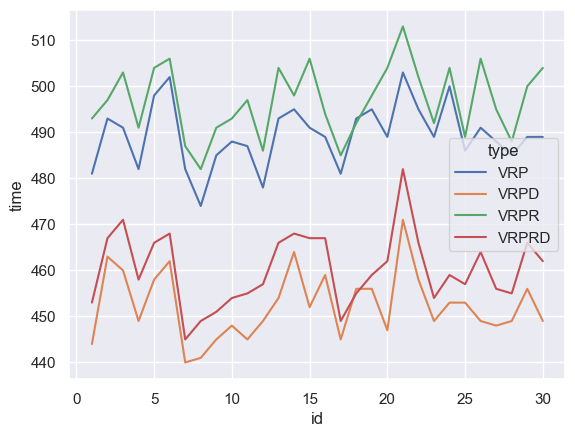

In [170]:
sns.lineplot(data=df_result, x='id', y='time', hue='type')

11/24

- 限制派出的次數上限，派出越多次省越多時間
- VRPD 會派出最多次, 故通常最省時間